[![PALS0039 Logo](https://www.phon.ucl.ac.uk/courses/pals0039/images/pals0039logo.png)](https://www.phon.ucl.ac.uk/courses/pals0039/)

# Exercise 8.2 Grapheme to phoneme conversion

In this exercise we construct a sequence-to-sequence model to address the problem of grapheme to phoneme conversion. We use an English pronunciation dictionary called BEEP which has been converted to the [SAMPA machine readable pronunciation](https://www.phon.ucl.ac.uk/home/sampa/) format.

The training data looks like this:
```
PRONOUN	      pr@UnaUn
PRONOUN'S	    pr@UnaUnz
PRONOUNCE	    pr@naUns
PRONOUNCEABLE	pr@naUns@bl
```

**Hint:** Use Ex. 8.1 as an example to complete this exercise.

---
Set up the environment:

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.utils import to_categorical, plot_model
from IPython.display import Image

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


---
Load the pronunciation dictionary:

In [ ]:
# the dictionary has pairs of input spelling and target transcription
url = "https://www.phon.ucl.ac.uk/courses/pals0039/data/exercise_08/english-dictionary.csv"

# read the dictionary using Pandas
df = pd.read_csv(url,keep_default_na=False)

# inspect
df

,INPUT,TARGET
0,'AVE,{v
1,'CAUSE,kO:z
2,'COS,kQz
3,'EM,@m
4,'EMPTY,empti:
...,...,...
256987,ZYGOMA,zaIg@Um@
256988,ZYGOMATA,zaIg@Um@t@
256989,ZYMOSCOPE,zaIm@Usk@Up
256990,ZYMOSIS,zaIm@UsIs


---
Create the input and output vocabulary of symbols:

In [ ]:
# get list of all characters used in orthography
inputs = df.INPUT.to_list()
input_chars = sorted(list(set("".join(inputs))))

# add space as a special character
input_chars.append(' ')
print("Orthography:", input_chars)

# get list of all the characters used in transcription
targets = df.TARGET.to_list()
target_chars = sorted(list(set("".join(targets))))

# add space and square brackets as special characters - we will use these as start and end symbols
target_chars.append('[')
target_chars.append(']')
print("SAMPA symbols:", target_chars)

Orthography: ["'", '-', '.', '5', '6', '<', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', '^', '_', '`', '~', ' ']
SAMPA symbols: ['3', ':', '@', 'A', 'D', 'I', 'N', 'O', 'Q', 'S', 'T', 'U', 'V', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'r', 's', 't', 'u', 'v', 'w', 'z', '{', '[', ']']


---
Get basic parameters for the model:

In [ ]:
# number of pronunciations
num_samples=len(df)

# number of different tokens used in orthography
num_encoder_tokens = len(input_chars)

# number of different tokens used in transcription
num_decoder_tokens = len(target_chars)

# maximum lengths of words and pronunciations
max_encoder_seq_length = max([len(txt) for txt in df.INPUT.to_list()])
max_decoder_seq_length = max([len(txt) for txt in df.TARGET.to_list()]) + 2   # plus 2 for BOS=[ and EOS=]

print('Number of samples:', num_samples)
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

# create mappings for both sets
orth_to_chr = dict(enumerate(input_chars))
orth_to_idx = {v: k for k, v in orth_to_chr.items()}
phon_to_chr = dict(enumerate(target_chars))
phon_to_idx = {v: k for k, v in phon_to_chr.items()}

Number of samples: 256992
Number of unique input tokens: 38
Number of unique output tokens: 38
Max sequence length for inputs: 28
Max sequence length for outputs: 32


---
Prepare the training data:

In [ ]:
# create list of encoder input sequences: padded with spaces and converted to indices:
encin_data = []
for word in df["INPUT"]:
  padded_word = word.ljust(max_encoder_seq_length, " ")
  encin_data.append(list(map(orth_to_idx.get, padded_word)))
encin_data = np.array(encin_data)

# create lists of decoder target and decoder input sequences: add `[` and `]`, pad and convert to indices:
decout_data = []
decin_data = []
for pronun in df["TARGET"]:
  padded_pronun = ("[" + pronun + "]").ljust(max_decoder_seq_length + 1, "]")
  padded_pronun_idxs = list(map(phon_to_idx.get, padded_pronun))
  decout_data.append(padded_pronun_idxs[1:])
  decin_data.append(padded_pronun_idxs[:-1])
decout_data = np.array(decout_data)
decin_data = np.array(decin_data)

# shuffle and one-hot encode
nseq = len(encin_data)
p = np.random.permutation(nseq)
encin_train = to_categorical(encin_data[p])
decin_train = to_categorical(decin_data[p])
decout_train = to_categorical(decout_data[p])

# inspect
print(encin_train.shape, decin_train.shape, decout_train.shape)

(256992, 28, 38) (256992, 32, 38) (256992, 32, 38)


---
(a) Construct the sequence-to-sequence model for training.

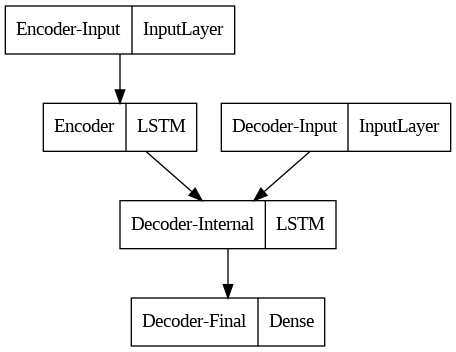

In [ ]:
#(a)
iwidth = num_encoder_tokens
owidth = num_decoder_tokens
internal_size = 256

# build the encoder network
encin = Input(shape=(None, iwidth), name="Encoder-Input")
encoder = LSTM(internal_size, return_state=True, name="Encoder")
encout, encstate_h, encstate_c = encoder(encin)
#encout, encstate_h, encstate_c = LSTM(internal_size, return_state=True, name="Encoder")(encin)
# we won't use the encoder outputs -- we only need the states
encstates = [encstate_h, encstate_c]

# we set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them
# during decoding.
decin = Input(shape=(None, owidth), name="Decoder-Input")
decoder_internal = LSTM(internal_size, return_sequences=True, return_state=True, name="Decoder-Internal")
decout_internal, decstate_h, decstate_c = decoder_internal(decin, initial_state=encstates)
decoder_final = Dense(owidth, activation="softmax", name="Decoder-Final")
decout = decoder_final(decout_internal)

# combine the encoder and decoder for training
model = Model([encin, decin], decout)

# compile and inspect the model
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
plot_model(model, show_layer_names=True, to_file="model.png")
Image(filename="model.png")

---
(b) Train the model

In [ ]:
#(b)
training_info = model.fit([encin_train, decin_train], decout_train, batch_size=64, epochs=5, validation_split=0.05)

Epoch 1/5
3815/3815 [==============================] - 108s 26ms/step - loss: 0.5075 - accuracy: 0.8490 - val_loss: 0.2226 - val_accuracy: 0.9291
Epoch 2/5
3815/3815 [==============================] - 92s 24ms/step - loss: 0.1557 - accuracy: 0.9497 - val_loss: 0.1146 - val_accuracy: 0.9625
Epoch 3/5
3815/3815 [==============================] - 90s 24ms/step - loss: 0.0950 - accuracy: 0.9688 - val_loss: 0.0805 - val_accuracy: 0.9735
Epoch 4/5
3815/3815 [==============================] - 98s 26ms/step - loss: 0.0716 - accuracy: 0.9762 - val_loss: 0.0665 - val_accuracy: 0.9777
Epoch 5/5
3815/3815 [==============================] - 88s 23ms/step - loss: 0.0586 - accuracy: 0.9802 - val_loss: 0.0573 - val_accuracy: 0.9806


---
Plot and examine the training graphs:

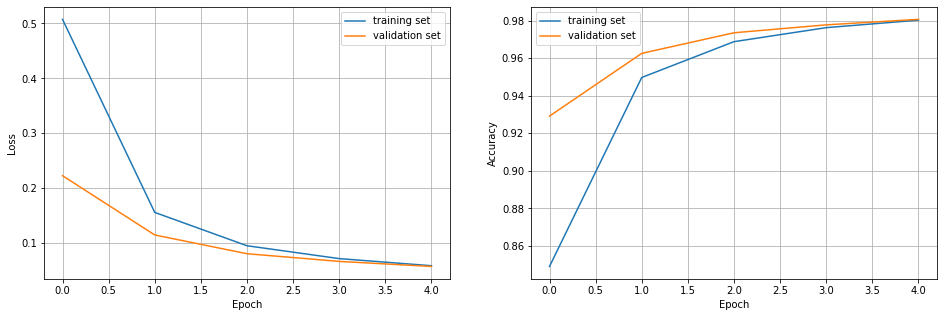

In [ ]:
def plot_training_history(training_info):
  # Plot the training process:
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))
  axs[0].plot(training_info.history['loss'], label="training set")
  axs[0].plot(training_info.history['val_loss'], label="validation set")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].grid(True)
  axs[0].legend()
  try:
    axs[1].plot(training_info.history['accuracy'], label="training set")
    axs[1].plot(training_info.history['val_accuracy'], label="validation set")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()
  except:
    pass
  plt.show()

plot_training_history(training_info)

---
(c) Build the sequence-to-sequence application using the trained encoder-decoder pair:

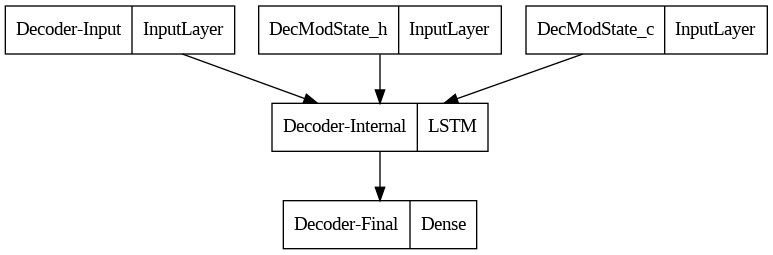

In [ ]:
#(c)
# define sampling models
encmod = Model(encin, encstates)

decmodstate_in_h = Input(shape=(internal_size,), name="DecModState_h")
decmodstate_in_c = Input(shape=(internal_size,), name="DecModState_c")
decmodstate_in = [decmodstate_in_h, decmodstate_in_c]
decmodout_internal, decmod_state_h, decmod_state_c = decoder_internal(decin, initial_state=decmodstate_in)
decmod_states = [decmod_state_h, decmod_state_c]
decmod_out = decoder_final(decmodout_internal)
decmod = Model([decin] + decmodstate_in, [decmod_out] + decmod_states)

# inspect decoder network
plot_model(decmod, show_layer_names=True, to_file="model.png")
Image(filename="model.png")

---
(d) Implement sampling from the output distribution to decode sequences:

In [ ]:
#(d)
def decode_sequence(input_seq):
  # reshape input into tensor of size 1
  input_tensor = input_seq.reshape(1, *input_seq.shape)
  # encode the input as state vectors.
  states = encmod.predict(input_tensor,verbose=False)
  # create empty target sequence of length 1.
  target_seq = np.zeros((1, 1, owidth))
  # Populate the first element of target sequence with the start symbol `[`.
  target_seq[0, 0, phon_to_idx["["]] = 1.0

  # Sampling loop for a batch of sequences
  # (to simplify, here we assume a batch of size 1)
  outsyms = ""
  while True:
    outvec, outstate_h, outstate_c = decmod.predict([target_seq] + states, verbose=False)
    outidx = np.argmax(outvec[0, -1])
    outsym = phon_to_chr[outidx]

    # Update the target sequence (of length 1)
    target_seq = np.zeros((1, 1, owidth))
    target_seq[0, 0, outidx] = 1.0

    # Update states
    states = [outstate_h, outstate_c]

    # Exit condition: either hit max length
    # or find stop character.
    if (outsym == ']' or len(outsyms) >= max_decoder_seq_length):
      break
    else:
      outsyms += outsym

  return outsyms

---
(e) Try out model with some samples -- think of some words to inspect the pronunciations.

In [ ]:
#(e)
trial_words = set("Twas brillig and the slithy toves Did gyre and gimble in the wabe All mimsy were the borogoves And the mome raths outgrabe".split())

def encode_orth(word):
  word = word.upper().ljust(max_encoder_seq_length, " ")
  vecs = np.zeros((len(word), num_encoder_tokens))
  for i, idx in enumerate(map(orth_to_idx.get, word)):
    vecs[i, idx] = 1.0
  return vecs

for word in trial_words:
  pronun = decode_sequence(encode_orth(word))
  print(word.upper(), pronun, sep="\t")


SLITHY	slIDi:
AND	{nd
AND	{nd
TWAS	twQs
ALL	O:l
RATHS	r{Ts
OUTGRABE	aUtgreIb
WABE	weIb
BRILLIG	brIlIg
GIMBLE	dZImbl
BOROGOVES	b@rQg@Uvz
THE	D@
GYRE	dZaI@
MOME	m@Um
WERE	we@r
DID	dId
TOVES	t@Uvz
IN	In
MIMSY	mImzi:
